# Modelo de Identificação de Fraudes

- Informações da base:
    - 'Time' (tempo): contém os segundos decorridos entre cada transação e a primeira transação no conjunto de dados. 
    - 'Amount' (valor): é o valor da transação 
    - 'Class' (classe): é a variável de resposta e assume valor 1 em caso de fraude e 0 caso contrário.
    - "Infelizmente, devido a questões de confidencialidade, não podemos fornecer os recursos originais e mais informações básicas sobre os dados. Características V1, V2, … V28 são os principais componentes obtidos com PCA"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

from scipy.stats import kstest, normaltest, anderson

from sklearn.preprocessing import PowerTransformer, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN

from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score,
    precision_recall_curve,
)

import warnings
from src.config import DADOS_MASTERCARD

warnings.filterwarnings('ignore')
sns.set_theme(palette="bright")

In [3]:
# Importando a baseall

transacoes = pd.read_csv(DADOS_MASTERCARD)

In [4]:
# Visualizando a base

transacoes.head(2)

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  

[2 rows x 31 columns]

In [5]:
# Verificando as informações

transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# E também o resumo estatístico

transacoes.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.654067e-16 -3.568593e-16  2.578648e-16  4.473266e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

In [7]:
# Verificando também se existem valores nulos

transacoes.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Qual o percentual de transações que são fraudes?**

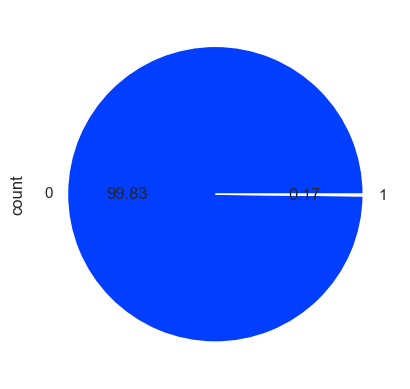

In [9]:
# Verificando visualmente o % de transações que são fraude

transacoes.Class.value_counts().plot.pie(autopct='%.2f');

In [10]:
# Verificar se todos os valores podem ser convertidos para inteiro (sem valores decimais)

if (transacoes['Time'] == transacoes['Time'].astype(int)).all():
    
    # Se todos os valores são inteiros, realizar a conversão
    
    transacoes['Time'] = transacoes['Time'].astype(int)
   
else:
    print("Nem todos os valores na coluna 'Time' podem ser convertidos para inteiro.")

In [11]:
transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  int32  
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### <font color='red'>Criando um modelo de aprendizado de máquinas para identificar fraude
- Vamos criar um modelo para identificar fraude sem fazer nenhum tratamento nessa base. **Pois, como acabamos de ver no gráfico, o dataset está desbalanceado.**

In [13]:
# Separando X e y

X = transacoes.drop('Class', axis=1)

y = transacoes.Class

In [14]:
# Separando em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [15]:
# Verificando a distribuição das duas classes na base de treino e teste

y_train.value_counts()/y_train.shape[0]

Class
0    0.998271
1    0.001729
Name: count, dtype: float64

In [16]:
# Para a base de teste

y_test.value_counts()/y_test.shape[0]

Class
0    0.998276
1    0.001724
Name: count, dtype: float64

### OBSERVAÇÃO:
- **Podemos observar que há uma diferença na proporção entre y_train e y_test. Por isso, temos que usar o parâmetro STRATIFY para manter a proporção entre treino e teste**

### Vamos utilizar o algorítimo Decision Trees com o dataset desbalandeado para observação.

In [19]:
# Definindo o nosso classificador

clfTree = tree.DecisionTreeClassifier(random_state=42, max_depth=3)

In [20]:
# Fazendo o fit para os dados de treino

clfTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [21]:
# Fazendo a previsão

y_pred = clfTree.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

**Verificando agora a matriz de confusão, a acurácia, precisão e o recall**

In [23]:
# Visualizando a matriz confusão

confusion_matrix(y_test, y_pred)

array([[93793,    32],
       [   42,   120]], dtype=int64)

### OBSERVAÇÃO:
- **Podemos observar, pela matrix de confusão, que a fraude, ou seja o que é 1, acertamos 122 e erramos 40. O que é um erro muito alto.**

In [25]:
# Calculando a acurácia

accuracy_score(y_test, y_pred)

0.9992126570695947

In [26]:
# Calculando a precisão

precision_score(y_test, y_pred)

0.7894736842105263

In [27]:
# E o recall

recall_score(y_test, y_pred)

0.7407407407407407

### OBSERVAÇÃO:
- **Podemos observar que, já que queremos detectar fraudes, ou seja o que é 1, precisamos melhorar a precisão e o recall.**

### <font color='red'>Criando um modelo de aprendizado de máquinas para identificar fraude - BALANCEANDO O DATASET

## Selecionando de forma aleatória

#### <font color='red'>Realizando o random undersampling

In [32]:
# Definindo o RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

In [33]:
# Definindo a nova amostra

X_res, y_res = rus.fit_resample(X_train, y_train)

In [34]:
# Verificando a quantidade de valores de y

print('Quantidade de y:')
display(y.value_counts())

print('Quantidade de y_train:')
display(y_train.value_counts())

print('Quantidade de y_res:')
display(y_res.value_counts())

Quantidade de y:


Class
0    284315
1       492
Name: count, dtype: int64

Quantidade de y_train:


Class
0    190490
1       330
Name: count, dtype: int64

Quantidade de y_res:


Class
0    330
1    330
Name: count, dtype: int64

**Voltando ao algoritmo Decison Trees. Agora com o dataset balanceado.**

In [36]:
# Fazendo o fit para os dados de treino já balanceados

clfTree_RUS = tree.DecisionTreeClassifier(random_state=42, max_depth=3)

clfTree_RUS.fit(X_res, y_res)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [37]:
# Fazendo a previsão para os dados de teste

y_pred_RUS = clfTree_RUS.predict(X_test)
y_pred_RUS

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [38]:
# Visualizando a matriz confusão

confusion_matrix(y_test, y_pred_RUS)

array([[90661,  3164],
       [   21,   141]], dtype=int64)

In [39]:
# Calculando a acurácia

accuracy_score(y_test, y_pred_RUS)

0.966112334684584

In [40]:
# Calculando a precisão

precision_score(y_test, y_pred_RUS)

0.04266263237518911

In [41]:
# Calculando o recall

recall_score(y_test, y_pred_RUS)

0.8703703703703703

#### Vamos usar o datetime para nos dar uma ideia do tempo de processamento

#### <font color='red'>Realizando o random oversampling

In [44]:
# Definindo o ros

print(dt.datetime.now())

ros = RandomOverSampler(random_state=42, shrinkage=0.5)

# Refazendo nossa amostra

X_res, y_res = ros.fit_resample(X_train, y_train)

print(dt.datetime.now())

2025-02-25 16:55:42.144945
2025-02-25 16:55:42.623312


In [45]:
# Verificando a quantidade de valores de y

print('Quantidade de y:')
display(y.value_counts())

print('Quantidade de y_train:')
display(y_train.value_counts())

print('Quantidade de y_res:')
display(y_res.value_counts())

Quantidade de y:


Class
0    284315
1       492
Name: count, dtype: int64

Quantidade de y_train:


Class
0    190490
1       330
Name: count, dtype: int64

Quantidade de y_res:


Class
0    190490
1    190490
Name: count, dtype: int64

In [46]:
# Fazendo o fit para os dados de treino já balanceados

print(dt.datetime.now())

clfTree_ROS = tree.DecisionTreeClassifier(random_state=42, max_depth=3)

clfTree_ROS.fit(X_res, y_res)

print(dt.datetime.now())

2025-02-25 16:55:42.654593
2025-02-25 16:55:50.928594


In [47]:
# Fazendo a previsão para os dados de teste

y_pred_ROS = clfTree_ROS.predict(X_test)
y_pred_ROS

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [48]:
# Visualizando a matriz confusão

confusion_matrix(y_test, y_pred_ROS)

array([[90706,  3119],
       [   21,   141]], dtype=int64)

In [49]:
# Calculando a acurácia

accuracy_score(y_test, y_pred_ROS)

0.9665911243044251

In [50]:
# Calculando a precisão

precision_score(y_test, y_pred_ROS)

0.04325153374233129

In [51]:
# Calculando o recall

recall_score(y_test, y_pred_ROS)

0.8703703703703703

## Usando outras formas de undersampling

#### <font color='red'>ClusterCentroids

In [54]:
# Definindo

print(dt.datetime.now())

cc = ClusterCentroids(random_state=42)

# Criando a amostra dos dados

X_res, y_res = cc.fit_resample(X_train, y_train)

print(dt.datetime.now())

2025-02-25 16:55:51.116607
2025-02-25 16:55:58.387122


**-> Gerando o modelo de classificação (Decision Trees) para o ClusterCentroids.**

In [56]:
# Fazendo o fit para os dados de treino já balanceados

print(dt.datetime.now())

clfTree_US_cc = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
clfTree_US_cc.fit(X_res, y_res)

# Fazendo a previsão para os dados de teste

y_pred_cc = clfTree_US_cc.predict(X_test)

print(dt.datetime.now())

2025-02-25 16:55:58.415724
2025-02-25 16:55:58.439898


In [57]:
# Visualizando a matriz confusão

confusion_matrix(y_test, y_pred_cc)

array([[28069, 65756],
       [    3,   159]], dtype=int64)

#### <font color='red'>NearMiss

In [59]:
# Fazendo a reamostragem usando o NearMiss

print(dt.datetime.now())

nm = NearMiss()
X_res, y_res = nm.fit_resample(X_train, y_train)

print(dt.datetime.now())

2025-02-25 16:55:58.483977
2025-02-25 16:55:58.751775


**-> Gerando o modelo de classificação (Decision Trees) para o NearMiss.**

In [61]:
# Fazendo o fit para os dados de treino já balanceados

print(dt.datetime.now())

clfTree_US_nm = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
clfTree_US_nm.fit(X_res, y_res)

# Fazendo a previsão para os dados de teste

y_pred_nm = clfTree_US_nm.predict(X_test)

print(dt.datetime.now())

2025-02-25 16:55:58.779215
2025-02-25 16:55:58.806827


In [62]:
# Visualizando a matriz confusão

confusion_matrix(y_test, y_pred_nm)

array([[57210, 36615],
       [    6,   156]], dtype=int64)

## E outras formas de oversampling

#### <font color='red'>Mudando os parâmetros do random oversampling

In [65]:
# Definindo o ros com shrinkage

print(dt.datetime.now())

ros = RandomOverSampler(random_state=42,shrinkage=0.9)

# Refazendo nossa amostra

X_res, y_res = ros.fit_resample(X_train, y_train)

print(dt.datetime.now())

2025-02-25 16:55:58.873615
2025-02-25 16:55:59.312682


In [66]:
# Fazendo o fit para os dados de treino já balanceados

print(dt.datetime.now())

clfTree_ROS2 = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
clfTree_ROS2.fit(X_res, y_res)

# Fazendo a previsão para os dados de teste

y_pred_ROS2 = clfTree_ROS2.predict(X_test)

print(dt.datetime.now())

2025-02-25 16:55:59.322487
2025-02-25 16:56:07.359221


In [67]:
# Visualizando a matriz confusão

confusion_matrix(y_test, y_pred_ROS2)

array([[92000,  1825],
       [   24,   138]], dtype=int64)

#### <font color='red'>SMOTE

In [69]:
# Utilizando o SMOTE

print(dt.datetime.now())

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print(dt.datetime.now())

2025-02-25 16:56:07.400751
2025-02-25 16:56:07.774132


**-> Gerando o modelo de classificação (Decision Trees) para o SMOTE.**

In [71]:
# Fazendo o fit para os dados de treino já balanceados

print(dt.datetime.now())

clfTree_OS_SMOTE = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
clfTree_OS_SMOTE.fit(X_res, y_res)

# Fazendo a previsão para os dados de teste

y_pred_OS_SMOTE = clfTree_OS_SMOTE.predict(X_test)

print(dt.datetime.now())

2025-02-25 16:56:07.822644
2025-02-25 16:56:16.311212


In [72]:
# Visualizando a matriz confusão

confusion_matrix(y_test, y_pred_OS_SMOTE)

array([[92078,  1747],
       [   24,   138]], dtype=int64)

#### <font color='red'>ADASYN

In [74]:
# Utilizando ADASYN

print(dt.datetime.now())

ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X_train, y_train)

print(dt.datetime.now())

2025-02-25 16:56:16.348117
2025-02-25 16:56:16.796794


**-> Gerando o modelo de classificação (Decision Trees) para o ADASYN.**

In [76]:
# Fazendo o fit para os dados de treino já balanceados

print(dt.datetime.now())

clfTree_OS_ADASYN = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
clfTree_OS_ADASYN.fit(X_res, y_res)

# Fazendo a previsão para os dados de teste

y_pred_OS_ADASYN = clfTree_OS_ADASYN.predict(X_test)

print(dt.datetime.now())

2025-02-25 16:56:16.821740
2025-02-25 16:56:24.198767


In [77]:
# Visualizando a matriz confusão

confusion_matrix(y_test, y_pred_OS_ADASYN)

array([[91974,  1851],
       [   23,   139]], dtype=int64)

## Combinando os métodos

#### <font color='red'>Utilizando o SMOTEENN

In [79]:
# Utilizando o SMOTEENN

print(dt.datetime.now())

sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_resample(X_train, y_train)

print(dt.datetime.now())

2025-02-25 16:56:24.241796
2025-02-25 16:57:44.594851


**-> Gerando o modelo de classificação (Decision Trees) para o SMOTEENN.**

In [81]:
# Fazendo o fit para os dados de treino já balanceados

print(dt.datetime.now())

clfTree_SMOTEENN = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
clfTree_SMOTEENN.fit(X_res, y_res)

# Fazendo a previsão para os dados de teste

y_pred_SMOTEENN = clfTree_SMOTEENN.predict(X_test)

print(dt.datetime.now())

2025-02-25 16:57:44.645823
2025-02-25 16:57:51.428872


In [82]:
# Visualizando a matriz confusão

confusion_matrix(y_test, y_pred_SMOTEENN)

array([[92562,  1263],
       [   25,   137]], dtype=int64)

**- Ao utilizarmos o datetime pudemos perceber que ADASYN e SMOTEENN aumentam o custo computacional.**<br>
**- Random Oversampling só é viável altarando o hiperparâmeto shrinkage para 0.9.**<br>
**- OBS.: Abandonaremos a ideia de realizar o Random Oversampling devido ao elevando número de dados já existente.**